In [1]:
import pandas as pd
from google.colab import drive
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
import tensorflow as tf
import glob
import cv2

In [2]:
#Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read input images and assign labels based on folder names
print(os.listdir("/content/drive/MyDrive/defect classification/casting_data/casting_data"))

SIZE = 128  #Resize images

['test', 'train']


In [4]:
#Capture training data and labels into respective lists
train_images = []
train_labels = []

for directory_path in glob.glob("/content/drive/MyDrive/defect classification/casting_data/casting_data/train/*"):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

def_front
ok_front


In [5]:
train_images.shape

(6633, 128, 128, 3)

In [6]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = []
for directory_path in glob.glob("/content/drive/MyDrive/defect classification/casting_data/casting_data/test/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpeg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
np.unique(train_labels)

array(['def_front', 'ok_front'], dtype='<U9')

In [8]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

In [9]:
print(np.unique(train_labels_encoded))

[0 1]


In [10]:
# Data already splitted but assigning to meaningful convention
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [11]:
# Create a copy of x_train and x_test for later use
x_train_original = np.copy(x_train)
x_test_original = np.copy(x_test)

# Create an ImageDataGenerator with rescale parameter set to normalize pixel values between 0 and 1
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Define batch size for normalization
batch_size = 32

# Create a generator for training data
train_gen = datagen.flow(x_train, batch_size=batch_size, shuffle=False)

# Create a generator for test data
test_gen = datagen.flow(x_test, batch_size=batch_size, shuffle=False)

# Iterate through the training data in batches and normalize pixel values
for i in range(len(x_train) // batch_size + 1):
    batch = train_gen[i]
    x_train[i * batch_size: (i + 1) * batch_size] = batch

# Iterate through the test data in batches and normalize pixel values
for i in range(len(x_test) // batch_size + 1):
    batch = test_gen[i]
    x_test[i * batch_size: (i + 1) * batch_size] = batch


In [12]:
#Load model wothout classifier/fully connected layers
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in resnet_model.layers:
	layer.trainable = False

resnet_model.summary()  #Trainable parameters will be 0

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [13]:
#use features from convolutional network for xgboostclassifier
feature_extractor=resnet_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to xgboostclassifier

208/208 [==============================] - 474s 2s/step


In [14]:
X_for_training.shape

(6633, 32768)

In [15]:
#XGBOOST
import xgboost as xgb
import joblib

print("Number of visible GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))
model = xgb.XGBClassifier(tree_method='hist', predictor='cpu_predictor')

model.fit(X_for_training, y_train) #For sklearn no one hot encoding
model_filename = "xgboost_model.joblib"
joblib.dump(model, model_filename)

Number of visible GPUs: 0


['xgboost_model.joblib']

In [16]:
#Send test data through same feature extractor process
X_test_feature = resnet_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

23/23 [==============================] - 49s 2s/step


In [17]:
#Now predict using the trained RF model.
prediction = model.predict(X_test_features)
#Inverse le transform to get original label back.
prediction = le.inverse_transform(prediction)

In [18]:
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction))

Accuracy =  0.6223776223776224


<Axes: >

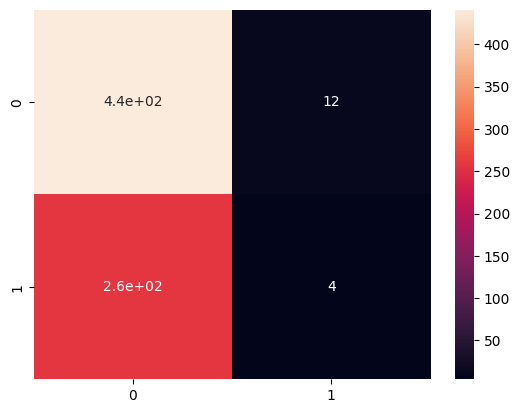

In [19]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, prediction)
#print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 0s 184ms/step
The prediction for this image is:  ['def_front']
The actual label for this image is:  def_front


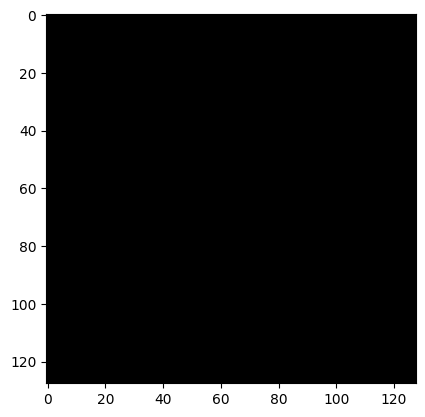

In [22]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature= resnet_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0]
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])